# Plant Pathology - Healthy, Layer 2 Analysis

In [1]:
import platform
import os
import random
import shutil
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms, utils
import PIL
from PIL import Image
import fastai
from fastai.vision.all import *
import sklearn
from sklearn import preprocessing, metrics
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

print('python version:      {}'.format(platform.python_version()))
print('fastai version:      {}'.format(fastai.__version__))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('PIL version:         {}'.format(PIL.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('umap version:        {}'.format(umap.__version__))
print('pandas version:      {}'.format(pd.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('seaborn version:     {}'.format(sns.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.7.10
fastai version:      2.3.0
torch version:       1.7.0
torchvision version: 0.8.1
PIL version:         7.2.0
sklearn version:     0.24.1
umap version:        0.5.1
pandas version:      1.2.3
numpy version:       1.19.5
matplotlib version:  3.4.1
seaborn version:     0.11.1
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


In [2]:
seed = 0

data_dir = Path('../input/plant-pathology-2020-fgvc7')
img_dir  = data_dir / 'images'

## Load Data

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv
/kaggle/input/plant-pathology-2020-fgvc7/train.csv
/kaggle/input/plant-pathology-2020-fgvc7/test.csv
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1743.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_262.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1524.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1336.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1461.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1797.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1499.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1170.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1259.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_422.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_636.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1395.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1800.jpg
/kaggle/input/plant-patholog

In [4]:
# Set Labels
train_df = pd.read_csv(data_dir/'train.csv')
labels = train_df.columns[1:]
train_df['label'] = train_df[labels].idxmax(1)

# Print Dataset Size and a few Samples
print('Samples: {}'.format(train_df.shape[0]))
print()
train_df.head()

Samples: 1821



,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [5]:
# Select Healthy Samples
train_df_healthy = pd.concat(
    [train_df.query('label == "healthy"')]
)

print('Healthy Samples: {}'.format(train_df_healthy.shape[0]))

Healthy Samples: 516


In [6]:
# Copy Healthy Images 
!mkdir healthy
healthy_dir = Path('./healthy')

healthy_fnames = list(train_df_healthy['image_id'])
healthy_fnames = [x + '.jpg' for x in healthy_fnames]
for x in healthy_fnames:
    shutil.copy(img_dir/x, healthy_dir)
    
healthy_dir.ls()

(#516) [Path('healthy/Train_195.jpg'),Path('healthy/Train_1479.jpg'),Path('healthy/Train_1666.jpg'),Path('healthy/Train_566.jpg'),Path('healthy/Train_337.jpg'),Path('healthy/Train_1457.jpg'),Path('healthy/Train_380.jpg'),Path('healthy/Train_249.jpg'),Path('healthy/Train_257.jpg'),Path('healthy/Train_1282.jpg')...]

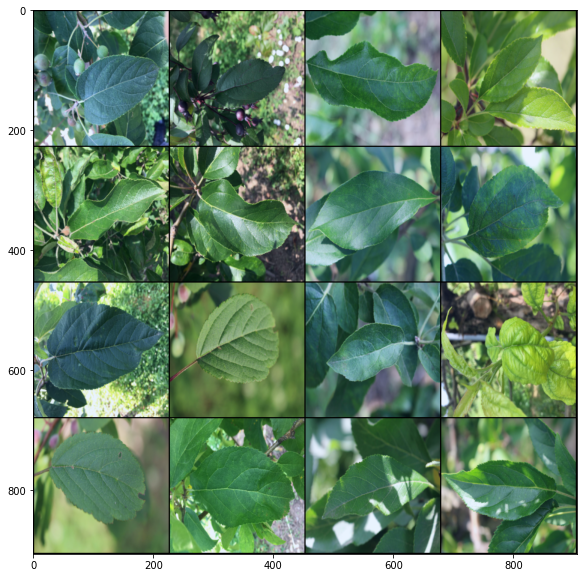

In [7]:
# Define SingleFolderDataset Class
class SingleFolderDataset(Dataset):
    def __init__(self, root, transform=None):
        self.img_paths = [os.path.join(root, img_path) for img_path in os.listdir(root)]
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return {'image': image, 'path': img_path}
    
# Define Function to Show Samples   
def show_sample_images(dataset, k=16):
    # Load sample images
    dataloader = DataLoader(dataset, batch_size=k, shuffle=True, num_workers=4)
    batch = next(iter(dataloader))
    images = batch['image']

    # Show sample images
    plt.rcParams['figure.figsize'] = (10, 10)
    grid = utils.make_grid(images, normalize=True, nrow=4)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    

# Create Healthy Class Dataset  
data_transform = transforms.Compose([
    transforms.Resize((224,224)), # or use: transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

healthy_dataset = SingleFolderDataset(
    root=healthy_dir, 
    transform=data_transform
)

# Create Healthy Class Dataloader
healthy_dataloader = DataLoader(healthy_dataset, batch_size=32, shuffle=False, num_workers=4)

# Show Sample Images
show_sample_images(healthy_dataset)

## Load Model

In [8]:
# Copy Model
!rm -rf models
!mkdir models
!cp ../input/pp-models/pp_base_vgg16_bn_s0.pth models

In [9]:
# Load Model
model = torch.load('models/pp_base_vgg16_bn_s0.pth', map_location=torch.device('cpu'))

## Layer Analysis

In [10]:
def generate_features(dataloader, model, layer):
    # Turn off require grad for the model and put it on CUDA (if available)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.eval().to(device)

    # Create lists for features and image paths
    features = []
    img_paths = []

    # Create hook for the features
    def hook(module, input, output):
        #activations = input[0].squeeze().detach().cpu().numpy()
        activations = output.squeeze().detach().cpu().numpy()
        features.append(activations)

    handle = layer.register_forward_hook(hook)

    # Create features
    for i, batch in enumerate(dataloader):
        print('Processing Batch %d' % (i))
        _ = model(batch['image'].to(device))
        #features = features[:-1]
        img_paths.append(batch['path'])

    print("done!")

    # Remove hook
    handle.remove()

    # Prepare the features and image paths for output
    features = np.concatenate(features)
    img_paths = pd.DataFrame({'img_path': np.concatenate(img_paths)})

    return {'feature': features, 'src_path': img_paths}

def normalize(features):
    scaler = preprocessing.StandardScaler()
    scaler.fit_transform(features)
    features = scaler.transform(features)
    print('Features normalized!')

    return features, scaler


def compress_data_pca(data, num_comp, verbose=True):
    transformer = PCA(n_components=num_comp)
    transformer.fit(data)
    compressed_data = transformer.transform(data)

    if verbose:
        explained_variance = np.sum(transformer.explained_variance_ratio_)
        print('Cumulative explained variation for %d principal components: %f' % (num_comp, explained_variance))
    
    return compressed_data, transformer

def compress_data_2d_tsne(data, perplexity=40, n_iter=1000, lr=200, verbose=True):
    if verbose:
        time_start = time.time()

        transformer = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter, learning_rate=lr)
        compressed_data = transformer.fit_transform(data)

        print('t-SNE done! Time elapsed: {} seconds.'.format(time.time()-time_start))
    else:
        transformer = TSNE(n_components=2, verbose=0, perplexity=perplexity, n_iter=n_iter, learning_rate=lr)
        compressed_data = transformer.fit_transform(data)
    
    return compressed_data

def compress_data_2d_umap(data, num_neighbors=15, metric='euclidean', n_epochs=None, learning_rate=1.0, 
                          init='spectral', min_dist=0.1, spread=1.0):
    transformer = umap.UMAP(n_components=2, n_neighbors=num_neighbors, metric=metric, n_epochs=n_epochs, 
                            learning_rate=learning_rate, init=init, min_dist=min_dist, spread=spread)
    transformer.fit(data)
    compressed_data = transformer.transform(data)
    
    return compressed_data

def cluster_data_kmeans(data, k_params):  
    best_k = None
    best_sh_score = None
    best_clusterer = None
        
    for k in k_params:
        clusterer = KMeans(init='k-means++', n_clusters=k)
        clusterer.fit(data)
            
        temp_sh_score = metrics.silhouette_score(data, clusterer.labels_, metric='euclidean')
        print('k = {}, Silhouette: {}'.format(k, temp_sh_score))
            
        if best_sh_score is None:
            best_k = k
            best_sh_score = temp_sh_score
            best_clusterer = clusterer
        elif best_sh_score < temp_sh_score:
            best_k = k
            best_sh_score = temp_sh_score
            best_clusterer = clusterer
            
    print()
    print('Best k = {}, Best Silhouette: {}'.format(best_k, best_sh_score))
            
    return {'label': best_clusterer.labels_, 'center': best_clusterer.cluster_centers_}   

def find_closest_samples(data, cluster_result, k=15):
    cluster_labels = np.unique(cluster_result['label'])
    
    cluster_data = {}
    cluster_indices = {}
    result = {}
    for l in cluster_labels:
        cluster_data[l] = []
        cluster_indices[l] = []
        result[l] = []
       
    for i, l in enumerate(cluster_result['label']):
        cluster_data[l].append(data[i])
        cluster_indices[l].append(i)
        
    
    for l in cluster_labels:
        cluster_data[l] = np.array(cluster_data[l])
        cluster_indices[l] = np.array(cluster_indices[l])
        distances = pairwise_distances([cluster_result['center'][l]], cluster_data[l])
        nearest_idx = list(np.argsort(distances, axis=1)[:,:k].flatten())
        nearest = list(cluster_data[l][nearest_idx])
        result[l] = cluster_indices[l][nearest_idx]

    return result

def find_farthest_samples(data, cluster_result, k=15):
    cluster_labels = np.unique(cluster_result['label'])
    
    cluster_data = {}
    cluster_indices = {}
    result = {}
    for l in cluster_labels:
        cluster_data[l] = []
        cluster_indices[l] = []
        result[l] = []
       
    for i, l in enumerate(cluster_result['label']):
        cluster_data[l].append(data[i])
        cluster_indices[l].append(i)
        
    
    for l in cluster_labels:
        cluster_data[l] = np.array(cluster_data[l])
        cluster_indices[l] = np.array(cluster_indices[l])
        distances = pairwise_distances([cluster_result['center'][l]], cluster_data[l])
        perc = np.percentile(distances, 70)
        temp = list(zip(list(cluster_indices[l]),list(distances[0])))
        temp = [x for x in temp if x[1] < perc]
        temp = sorted(temp, key=lambda tup: tup[1])[-k:]
        temp = [x[0] for x in temp]
        result[l] = temp

    return result

def plot_data_2d(data, clusters=None, cluster_centers=None, cluster_names=None, center_nearest_list=None, sample=None, adversarial=None):
    sns.set_context("notebook", font_scale=1.1)
    sns.set_style("ticks")
    
    # Put data in data frame
    df = pd.DataFrame()
    df['x'] = data[:,0]
    df['y'] = data[:,1]
    
    # Visualize data: if no cluster labels specified just plot, otherwise plot with cluster labels
    if clusters is None:
        sns.lmplot(x='x', y='y', data=df, fit_reg=False, height=6, aspect=1.5, palette="Set1",
                   scatter_kws={"marker": "D", "s": 50, "alpha": 0.6}).set_axis_labels('','')
    else:
        # Plot with cluster labels
        if cluster_names is None:
            df['labels'] = clusters
            legend_title = 'Clusters'
        else:
            cluster_labels = np.array(list(map(lambda x: str(cluster_names[x]), clusters)))
            df['labels'] = cluster_labels
            legend_title = 'Object Classes'
        
        plot = sns.lmplot(x='x', y='y', data=df, fit_reg=False, hue="labels", height=6, aspect=1.5,
           palette="muted", scatter_kws={"marker": "D", "s": 50, "alpha": 0.6}).set_axis_labels('','')
        plot._legend.set_title(legend_title)

        # If nearest data points to each cluster center specified, plot these as well
        if center_nearest_list is not None:                
            for center_nearest in center_nearest_list.keys():
                temp = data[center_nearest_list[center_nearest]]
                plt.plot(temp[:,0],temp[:,1], marker='o', fillstyle='none', color='lime', ls='', markersize=8)

        # If specified, plot cluster centers
        if cluster_centers is not None:
            plt.plot(*zip(*cluster_centers), marker='x', color='black', ls='', markersize=14, markeredgewidth=2)

### Project Activations
approach: https://arxiv.org/abs/1602.03616

In [11]:
layer = model[1][0]

In [12]:
# Fetch Activations
result = generate_features(healthy_dataloader, model, layer); result['feature'].shape

Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
Processing Batch 10
Processing Batch 11
Processing Batch 12
Processing Batch 13
Processing Batch 14
Processing Batch 15
Processing Batch 16
done!


(516, 1024)

In [13]:
# Flatten Activations
#result['feature'] = result['feature'].reshape(result['feature'].shape[0], -1)
#result['feature'].shape

In [14]:
# Normalize Activations
features, scaler = normalize(result['feature'])
img_paths = result['src_path']

print()
print('Feature Matrix Shape: ', features.shape)

Features normalized!

Feature Matrix Shape:  (516, 1024)


In [15]:
# Project Activations to 50D
precompressed_data, pca_transformer = compress_data_pca(features, num_comp=50)

print()
print('Feature Matrix Shape: ', precompressed_data.shape)

Cumulative explained variation for 50 principal components: 0.710236

Feature Matrix Shape:  (516, 50)


In [16]:
# Project Activations to 2D
compressed_data = compress_data_2d_umap(
    precompressed_data, metric='cosine', num_neighbors=15, min_dist=0.1
)

print()
print('Feature Matrix Shape: ', compressed_data.shape)


Feature Matrix Shape:  (516, 2)


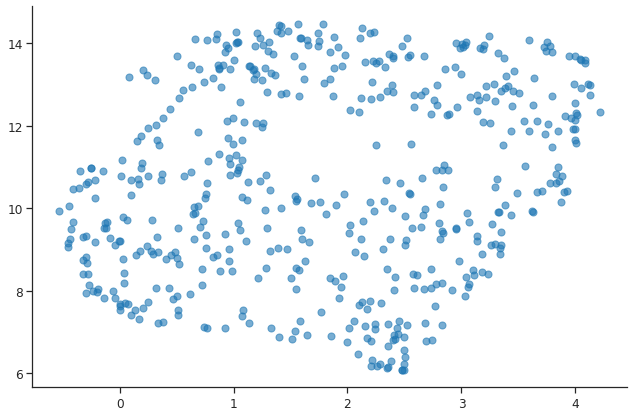

In [17]:
# Visualize Projected Activations
plot_data_2d(compressed_data)

### Select Samples

In [18]:
# Look for Clusters
cluster_result = cluster_data_kmeans(compressed_data, k_params=[2,3,4,5,6,7,8,9])

k = 2, Silhouette: 0.5068654417991638
k = 3, Silhouette: 0.40810713171958923
k = 4, Silhouette: 0.43250352144241333
k = 5, Silhouette: 0.42428264021873474
k = 6, Silhouette: 0.4497651755809784
k = 7, Silhouette: 0.4296664595603943
k = 8, Silhouette: 0.4077029228210449
k = 9, Silhouette: 0.3946034014225006

Best k = 2, Best Silhouette: 0.5068654417991638


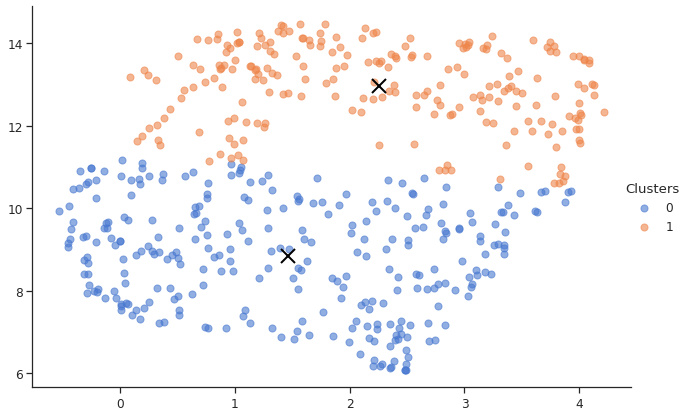

In [19]:
# Plot Clusters
plot_data_2d(compressed_data, cluster_result['label'], cluster_result['center'])

In [20]:
# Select Closest/Farthest Samples from each Found Cluster Center
sample_indices_farthest = find_farthest_samples(compressed_data, cluster_result, k=50)
sample_indices_closest = find_closest_samples(compressed_data, cluster_result, k=50)

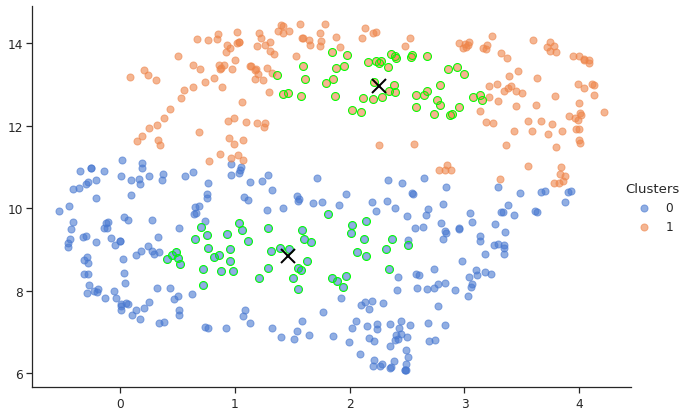

In [21]:
# Plot Closest Samples
plot_data_2d(
    compressed_data, cluster_result['label'], 
    cluster_result['center'], 
    center_nearest_list=sample_indices_closest
)

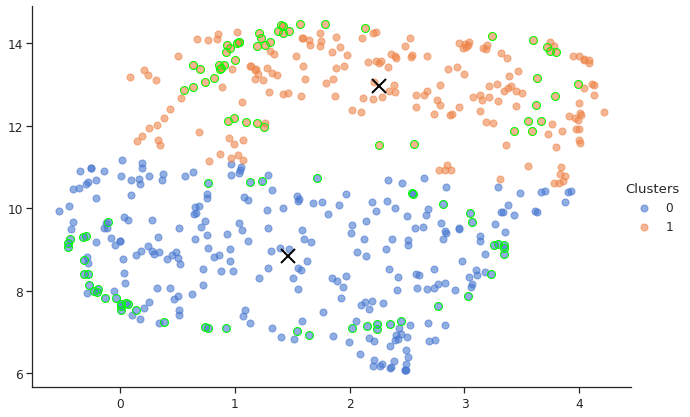

In [22]:
# Plot Farthest Samples
plot_data_2d(
    compressed_data, 
    cluster_result['label'], 
    cluster_result['center'], 
    center_nearest_list=sample_indices_farthest
)

In [23]:
# Find Indices of Closest Samples
sample_indices_closest = np.array(
    [sample_indices_closest[k] for k in sample_indices_closest.keys()]
).flatten()

# Find Indices of Farthest Samples
sample_indices_farthest = np.array(
    [sample_indices_farthest[k] for k in sample_indices_farthest.keys()]
).flatten()

# Find File Names of Closest Samples
sample_fnames_closest = list(pd.DataFrame(pd.DataFrame(
    img_paths.iloc[list(sample_indices_closest)]['img_path'].str.replace('.jpg', '')
)['img_path'].str.replace('healthy/', ''))['img_path'])

# Find File Names of Farthest Samples
sample_fnames_farthest = list(pd.DataFrame(pd.DataFrame(
    img_paths.iloc[list(sample_indices_farthest)]['img_path'].str.replace('.jpg', '')
)['img_path'].str.replace('healthy/', ''))['img_path'])

# Create DataFrame of Closest/Farthest Samples
healthy_train_df_closest = train_df[train_df['image_id'].isin(sample_fnames_closest)]
healthy_train_df_farthest = train_df[train_df['image_id'].isin(sample_fnames_farthest)]

(healthy_train_df_closest.shape, healthy_train_df_farthest.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.


((100, 6), (100, 6))

In [24]:
# Save DataFrame of Closest/Farthest Samples
healthy_train_df_closest.to_csv(
    'pp_train_df_undersamp_healthy_layer2_closest_vgg16_bn_s0.csv', index=False
)
healthy_train_df_farthest.to_csv(
    'pp_train_df_undersamp_healthy_layer2_farthest_vgg16_bn_s0.csv', index=False
)